In [1]:
import numpy as np
from reservoirpy import datasets
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import seaborn as sns


# Prediction Horizon
this is an evaluation metric for signal generation tasks, such as Mackey-Glass. With a 1 step ahead prediction model, the future prediction is repeatedly fed back into the input in order to predict further ahead. This happens without feedback from true labels. The prediction horizon is this case, is the number of steps that can be predicted, while not deviating from the label sequence. Formally, this means that the error stays below a certain threshold expressed a portion of the label variance.

## Label variance as a function of Tau
let's first look at how the label variance changes as a function of Mackey-Glass task timescale.

In [2]:
tau_range = np.array(range(12, 22))

<AxesSubplot: xlabel='tau', ylabel='sequence variance'>

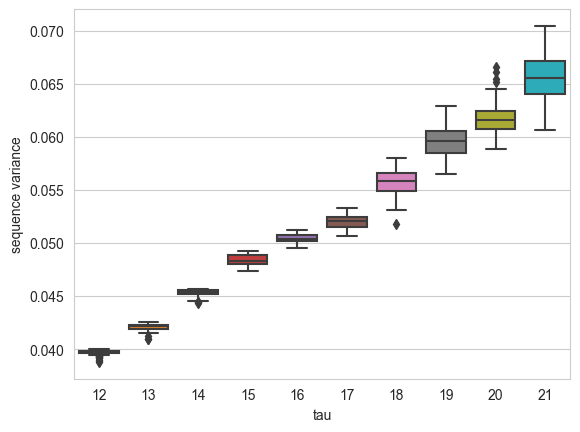

In [3]:
variance_overview = {
    'tau': [],
    'sequence variance': []
}
n_seq = 100
seq_len = 2000
for tau in tau_range:
    for s in range(n_seq):
        variance_overview['tau'].append(tau)
        x_0 = np.random.uniform(low=0.5, high=1.2)
        seq = datasets.mackey_glass(seq_len, tau=tau, x0=x_0)
        v = np.var(seq)
        variance_overview['sequence variance'].append(v)

pd_var_overview = pd.DataFrame.from_dict(variance_overview)
sns.boxplot(x='tau', y='sequence variance', data=pd_var_overview)

## Effect of error threshold
Load some optimized networks, and evaluate them on progressively decreasing error margins

In [3]:
evolution_data = {
    'ESN': {
        'fixed': {
            'path': "results-2023-paper/2022-12-08_b1_n300_k6_multiple_sequences_random_tau_adaptive_False_delays_False.p"},
        'BCM': {
            'path': "results-2023-paper/2022-12-05delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"}
    },
    'DDN': {
        'fixed': {
            'path': "results-2023-paper/2022-12-06delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"},
        'BCM': {
            'path': "results-2023-paper/2022-12-02delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"}
    }
}
# Load data
for net_type in evolution_data:
    for adaptive in evolution_data[net_type]:

        path = evolution_data[net_type][adaptive]['path']
        print("Loading hyperparameter optimization results from " + path)

        with open(path, 'rb') as f:
            results_dict = pkl.load(f)
        evolution_data[net_type][adaptive]['results_dict'] = results_dict


Loading hyperparameter optimization results from results-2023-paper/2022-12-08_b1_n300_k6_multiple_sequences_random_tau_adaptive_False_delays_False.p
Loading hyperparameter optimization results from results-2023-paper/2022-12-05delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p
Loading hyperparameter optimization results from results-2023-paper/2022-12-06delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p
Loading hyperparameter optimization results from results-2023-paper/2022-12-02delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p


Example with ESNs

In [15]:
from testOptimized import test_net, retrain_net

In [21]:
test_by_e_margin = {
    'Test Score': [],
    'Error Margin': [],
    'Tau': []
}

margin_grid = [.1, .05, .025, .0125, .005125]
tau_grid = range(12, 22)
for tau in tau_grid:
    val, model, net = retrain_net(evolution_data['ESN']['fixed']['results_dict'], tau)
    for em in margin_grid:
        test_data = [datasets.mackey_glass(1000, tau=tau, x0=np.random.uniform(low=0.5, high=1.2)) for i in range(10)]
        y_across_sequences, prediction_steps_across_sequences = test_net(net, model, em, test_data)
        test_by_e_margin['Test Score'] += prediction_steps_across_sequences
        test_by_e_margin['Error Margin'] += [em] * len(y_across_sequences)
        test_by_e_margin['Tau'] += [tau] * len(y_across_sequences)

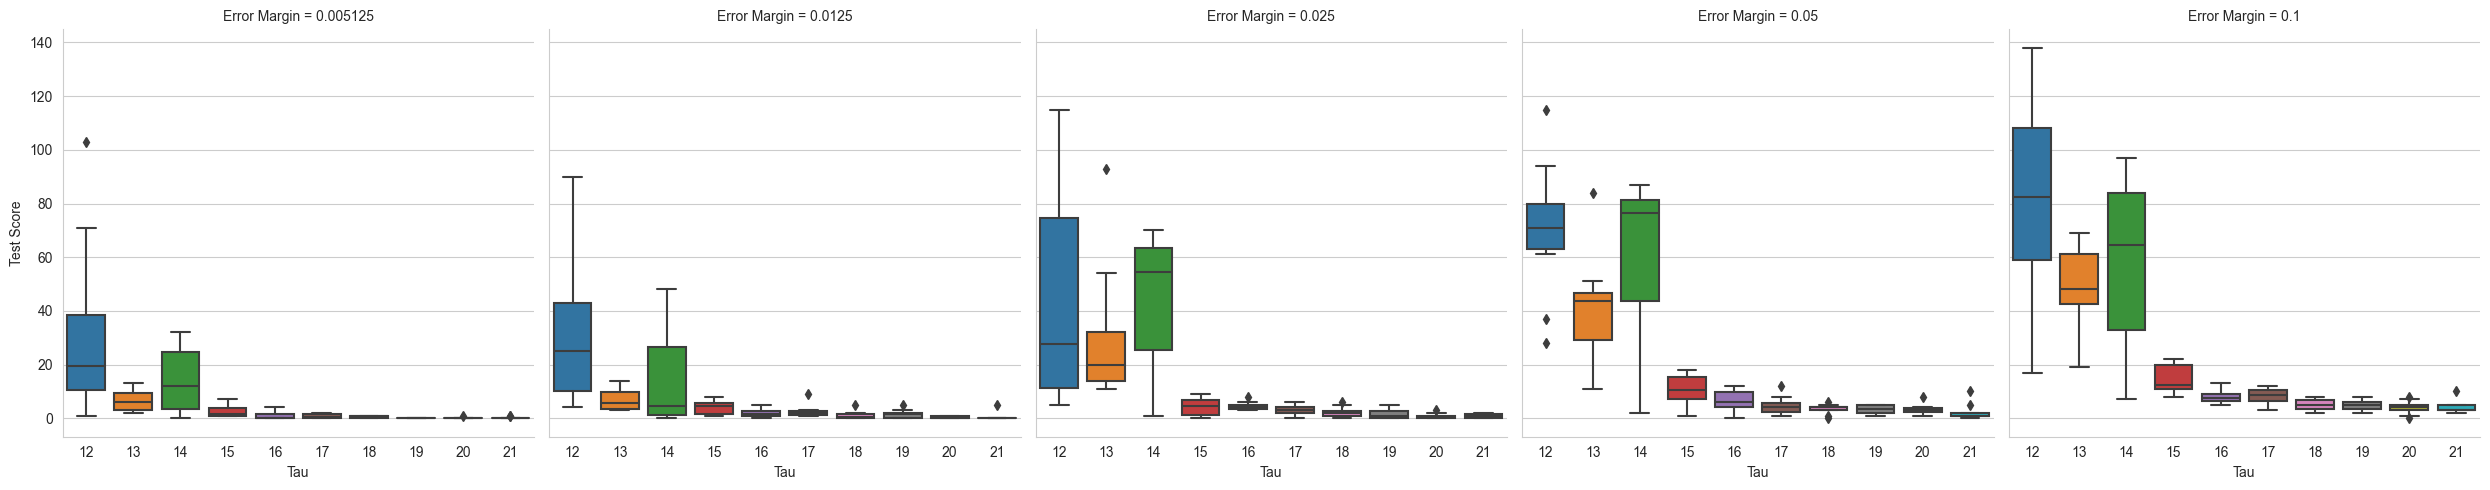

In [22]:
e_margin_df = pd.DataFrame.from_dict(test_by_e_margin)
# sns.boxplot(y='Test Score', x='Error Margin', data=e_margin_df)
sns.catplot(y='Test Score', x='Tau', data=e_margin_df, col='Error Margin', kind='box')